In [2]:
import h5py

def inspect_hdf(path):
    with h5py.File(path, 'r') as f:
        def print_group(name, obj):
            print(name)
        f.visititems(print_group)

inspect_hdf('Estimate_Biomass/InputData/GEDI_L4A/GEDI04_A_2022267201010_O21432_02_T09701_02_003_01_V002.h5')


ANCILLARY
ANCILLARY/model_data
ANCILLARY/pft_lut
ANCILLARY/region_lut
BEAM0000
BEAM0000/agbd
BEAM0000/agbd_pi_lower
BEAM0000/agbd_pi_upper
BEAM0000/agbd_prediction
BEAM0000/agbd_prediction/agbd_a1
BEAM0000/agbd_prediction/agbd_a10
BEAM0000/agbd_prediction/agbd_a2
BEAM0000/agbd_prediction/agbd_a3
BEAM0000/agbd_prediction/agbd_a4
BEAM0000/agbd_prediction/agbd_a5
BEAM0000/agbd_prediction/agbd_a6
BEAM0000/agbd_prediction/agbd_pi_lower_a1
BEAM0000/agbd_prediction/agbd_pi_lower_a10
BEAM0000/agbd_prediction/agbd_pi_lower_a2
BEAM0000/agbd_prediction/agbd_pi_lower_a3
BEAM0000/agbd_prediction/agbd_pi_lower_a4
BEAM0000/agbd_prediction/agbd_pi_lower_a5
BEAM0000/agbd_prediction/agbd_pi_lower_a6
BEAM0000/agbd_prediction/agbd_pi_upper_a1
BEAM0000/agbd_prediction/agbd_pi_upper_a10
BEAM0000/agbd_prediction/agbd_pi_upper_a2
BEAM0000/agbd_prediction/agbd_pi_upper_a3
BEAM0000/agbd_prediction/agbd_pi_upper_a4
BEAM0000/agbd_prediction/agbd_pi_upper_a5
BEAM0000/agbd_prediction/agbd_pi_upper_a6
BEAM0000/agbd_

In [3]:
import h5py
import pandas as pd

def read_gedi_l4a(path, beam='BEAM0000'):
    with h5py.File(path, 'r') as f:
        lat = f[f'{beam}/lat_lowestmode'][:]      # top-level, no suffix
        lon = f[f'{beam}/lon_lowestmode'][:]
        agb = f[f'{beam}/agbd'][:]                # biomass density
        quality = f[f'{beam}/l4_quality_flag'][:] # quality flag

    df = pd.DataFrame({
        'latitude': lat,
        'longitude': lon,
        'a_gha':     agb,
        'quality':   quality
    })
    return df[df['quality'] == 1].reset_index(drop=True)

# Test
gedi_df = read_gedi_l4a('Estimate_Biomass/InputData/GEDI_L4A/GEDI04_A_2022267201010_O21432_02_T09701_02_003_01_V002.h5')
print(gedi_df.head())


    latitude  longitude      a_gha  quality
0  15.978425 -97.500892  20.176065        1
1  15.989820 -97.491680  13.842820        1
2  15.991044 -97.490698  14.643175        1
3  15.991860 -97.490045  14.477285        1
4  15.996764 -97.486128  45.265266        1


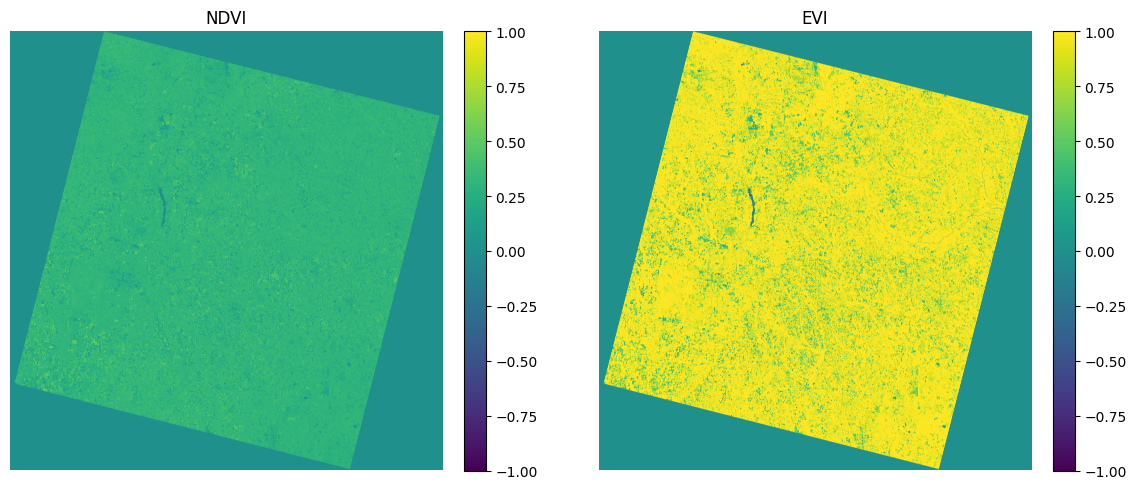

In [4]:
import rasterio
import numpy as np

import matplotlib.pyplot as plt


paths = {
    'blue':  'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B2.TIF',
    'green':   'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B3.TIF',
    'red':   'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B4.TIF',
    'nir':   'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B5.TIF',
    'swir1':   'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B6.TIF',
    'swir2':   'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B7.TIF',
    # etc for green (B3), swir1 (B6), swir2 (B7)
}


arrays = {}
profile = None
for name, p in paths.items():
    with rasterio.open(p) as src:
        arrays[name] = src.read(1).astype('float32') / 10000.0  # scale to [0,1]
        if profile is None:
            profile = src.profile

# NDVI = (NIR - Red) / (NIR + Red)
ndvi = (arrays['nir'] - arrays['red']) / (arrays['nir'] + arrays['red'] + 1e-6)
ndvi_profile = profile.copy()
ndvi_profile.update(dtype=rasterio.float32, count=1)

# Write NDVI out
with rasterio.open('ndvi.tif', 'w', **ndvi_profile) as dst:
    dst.write(ndvi.astype(rasterio.float32), 1)

# 
evi = 2.5 * (arrays['nir'] - arrays['red']) / \
      (arrays['nir'] + 6*arrays['red'] - 7.5*arrays['blue'] + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(ndvi, vmin=-1, vmax=1)
ax1.set_title('NDVI')
ax1.axis('off')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

im2 = ax2.imshow(evi, vmin=-1, vmax=1)
ax2.set_title('EVI')
ax2.axis('off')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [5]:
import rasterio
import numpy as np

#  DEM
dem_file = r'Estimate_Biomass\InputData\DEM.tif'
with rasterio.open(dem_file) as src:
    dem = src.read(1).astype('float32')
    transform = src.transform
    profile = src.profile

#  Compute the cell‐size in x and y (meters)
#    from the affine transform: a = pixel width, e = pixel height (negative)
a = transform.a
e = transform.e
dx = a
dy = -e

# Compute gradients (dz/dx, dz/dy) with central differences
#    np.gradient automatically uses edge‐aware one‐sided differences
dz_dy, dz_dx = np.gradient(dem, dy, dx)

#Slope in radians = arctan( sqrt(dz/dx² + dz/dy²) )
slope_rad = np.arctan(np.hypot(dz_dx, dz_dy))

# 5. Convert to degrees
slope_deg = np.degrees(slope_rad)

# write out a GeoTiff of slope
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open(r'Estimate_Biomass\slope_deg.tif', 'w', **profile) as dst:
    dst.write(slope_deg.astype(rasterio.float32), 1)


In [6]:
from rasterio.sample import sample_gen
predictor_paths = [
  'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B2.TIF',
    'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B3.TIF',
    'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B4.TIF',
    'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B5.TIF',
    'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B6.TIF',
    'Estimate_Biomass\InputData\LC09_L2SP_018038_20221004_20230327_02_T1\LC09_L2SP_018038_20221004_20230327_02_T1_SR_B7.TIF',
  'ndvi.tif',
  'slope_deg.tif'    
]

coords = [(x,y) for x,y in zip(gedi_df.longitude, gedi_df.latitude)]
samples = []
for p in predictor_paths:
    with rasterio.open(p) as src:
        vals = [v[0] for v in src.sample(coords)]
        samples.append(vals)


pred_df = pd.DataFrame(
  {name: arr for name, arr in zip(
    ['blue','green','red','nir','swir1','swir2','ndvi','slope'],
    samples
  )}
)
pred_df['a_gha'] = gedi_df['a_gha'].values

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split data
X = pred_df.drop(columns=['a_gha'])
y = pred_df['a_gha']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train RF
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R²: -0.0004931862134278653
RMSE: 79.69106136559249


In [ ]:
from rasterio.sample import sample_gen

# Combine all your predictor arrays into one 3D stack 

predictor_paths = [*paths.values(), 'ndvi.tif', 'slope.tif']
# (you’d first write ndvi/slope arrays as temp TIFFs if needed)

# 
coords = [(x,y) for x,y in zip(gedi_df.longitude, gedi_df.latitude)]
samples = []
for p in predictor_paths:
    with rasterio.open(p) as src:
        vals = [v[0] for v in src.sample(coords)]
        samples.append(vals)

# DataFrame of predictors + target
pred_df = pd.DataFrame({name: arr for name, arr in zip(
    ['blue','red','nir','ndvi','slope'], samples)})
pred_df['a_gha'] = gedi_df['a_gha'].values
